In [378]:
import pickle
import skfda
import pandas as pd
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt
import datetime
import numpy as np

# Andiamo a carcare il pickle salvato delle serie su ndvi

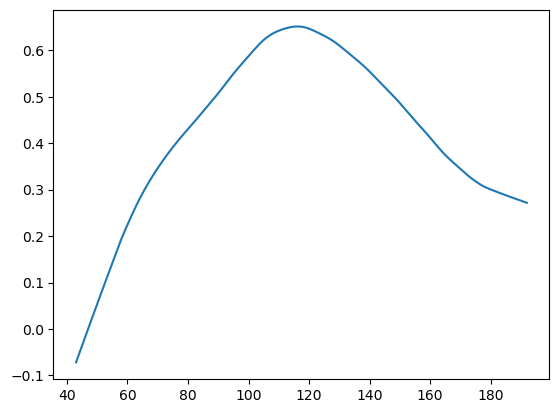

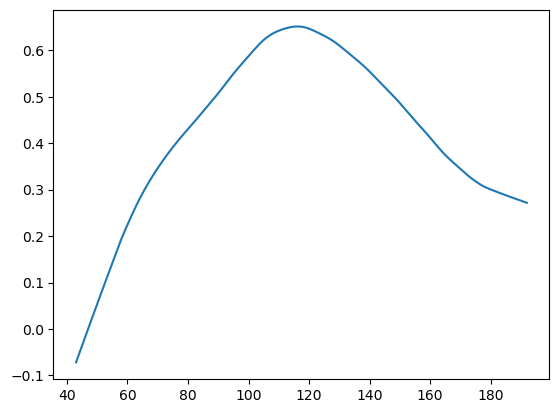

In [379]:
with open('hdvi.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
NDVI.mean().plot()

# Procediamo con l'addestramento di NeuralProphet

In [380]:
# Costruiamo il dataframe per l'addestramento
# Devo ricostruire le date

scostamento = 60
PTest = 120

rangeForNewDate = range(43,193)
rangeForNewDate2 = range(43,193-scostamento) # Pixel di prova per fare predizione


days = []
days2 = []
zeroDay = datetime.datetime.strptime("2017-01-01","%Y-%m-%d")

for a in rangeForNewDate:
    days.append((zeroDay + datetime.timedelta(days=a)))
serie = NDVI.mean().data_matrix.flatten()

for a in rangeForNewDate2:
    days2.append((zeroDay + datetime.timedelta(days=a)))
serie2 = NDVI[PTest].data_matrix.flatten()[:-(scostamento)]


d = {'ds': days, 'y': serie}
data = pd.DataFrame(data=d)
d2 = {'ds': days2, 'y': serie2}
data2 = pd.DataFrame(data=d2)
print(data2.shape)
data.head(5)

(90, 2)


,ds,y
0,2017-02-13,-0.072106
1,2017-02-14,-0.053907
2,2017-02-15,-0.035771
3,2017-02-16,-0.017700
4,2017-02-17,0.000303


# Eseguiamo l'addestramento

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (10) is too small than the required number for the learning rate finder (209). The results might not be optimal.


Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

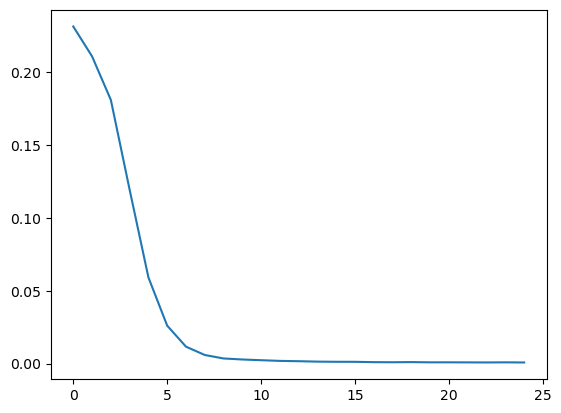

In [381]:
m = NeuralProphet()
model = m.fit(data, freq='D', epochs=25)
model['Loss'].plot()

# Facciamo la previsione

In [382]:
future = m.make_future_dataframe(data2, periods=scostamento)
forecast = m.predict(future)
forecast.head(5)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.889% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 10it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_weekly
0,2017-05-14,None,0.577899,0.575689,0.002210
1,2017-05-15,None,0.566410,0.570488,-0.004078
2,2017-05-16,None,0.564205,0.565288,-0.001083
3,2017-05-17,None,0.559131,0.560087,-0.000956
4,2017-05-18,None,0.554674,0.554886,-0.000212


# Stampa della previsione

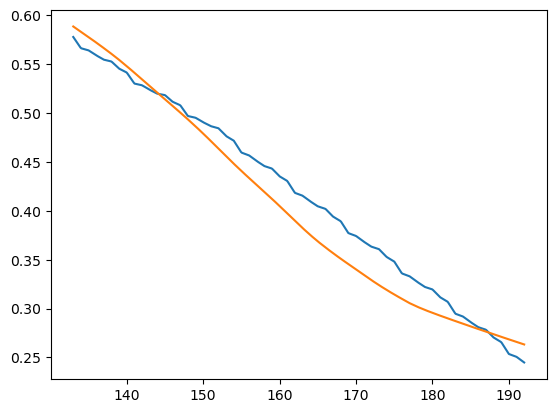

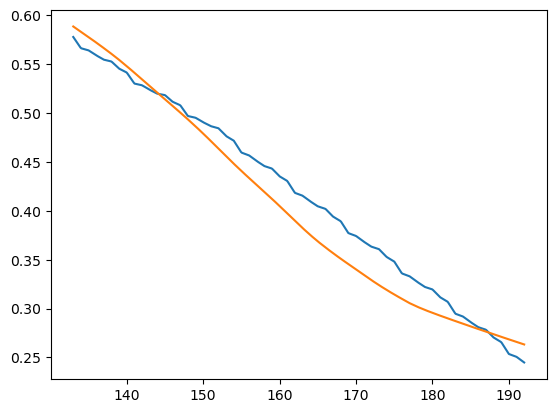

In [383]:
#plot1 = m.plot(forecast)
#print(forecast)
#NDVI[42].plot()
#print(NDVI[42].data_matrix.flatten()[70:].shape)
compare = skfda.FDataGrid(
    data_matrix=[forecast['yhat1'],NDVI[PTest].data_matrix.flatten()[150-scostamento:]],
    grid_points=range(193-scostamento,193),
)
compare.plot()

# Calcolo dei parametri MAE, MSE, RSME

In [384]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
  
# calculate MAE
error1 = np.round(mae(compare.data_matrix[1], compare.data_matrix[0]),6)

# display
print("Mean absolute error : " + str(error1))

# calculate MSE
error2 = round(mse(compare.data_matrix[1], compare.data_matrix[0]),6)
  
# display
print("Mean absolute error : " + str(error2))
# calculate RMSE
print("Mean absolute error : " + str(np.round(np.sqrt(error2),6)))

Mean absolute error : 0.019115
Mean absolute error : 0.000503
Mean absolute error : 0.022428
